In [219]:
import os
from pathlib import Path
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt

In [220]:
class MakeDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform):
        self.dir_length = len(os.listdir(image_dir))
        self.image_paths = sorted([f.resolve() for f in Path(image_dir).iterdir() if f.is_file()])
        self.mask_paths = sorted([f.resolve() for f in Path(mask_dir).iterdir() if f.is_file()])
        self.transform = transform

        print(f"file num: {self.dir_length}")

    def __getitem__(self, index):
        
        # 入力画像の読み込み
        img = cv2.imread(self.image_paths[index])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # マスクデータの読み込み
        mask = cv2.imread(self.mask_paths[index], cv2.IMREAD_GRAYSCALE)

        # 前処理が指定されていれば前処理を実行
        if self.transform is not None:
            transformd = self.transform(image = img, mask = mask)
            dicom_array, mask = transformd['image'], transformd['mask']

        # albuのToTensorはtorchvisionのToTensorのように規格化してくれないらしい
        dicom_array, mask = dicom_array / 255., mask / 255.

        # マスクの方にバッチ用の次元がないので追加
        mask = mask.unsqueeze(0)

        return dicom_array.to(torch.float32), mask.to(torch.float32)
    
    def __len__(self):
        return self.dir_length

In [221]:
train_path = "/src/Multiclass_Segmentation/data/train/"
valid_path = "/src/Multiclass_Segmentation/data/valid/"
test_path = "/src/Multiclass_Segmentation/data/test/"

train_dataset = MakeDataset(train_path + 'train_org', train_path + 'train_annotated', transform = ToTensorV2())
valid_dataset = MakeDataset(valid_path + 'valid_org', valid_path + 'valid_annotated', transform = ToTensorV2())
test_dataset = MakeDataset(test_path + 'test_org', test_path + 'test_annotated', transform = ToTensorV2())

BATCH_SIZE = 8
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, num_workers = 2, shuffle = True)
valid_loader = DataLoader(valid_dataset, batch_size = BATCH_SIZE, num_workers = 2, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, num_workers = 2, shuffle = False)

file num: 367
file num: 101
file num: 233


In [222]:
img, mask = train_dataset[0]
unique_value, unique_count = torch.unique(mask, return_counts = True)
print(f"クラス数：\n{unique_value}")
print(f"クラスごとのpixel数：\n{unique_count}")

クラス数：
tensor([0.0000, 0.0039, 0.0078, 0.0118, 0.0157, 0.0196, 0.0235, 0.0314, 0.0353,
        0.0431])
クラスごとのpixel数：
tensor([23726, 64726,  1904, 16139, 11897,  2303,  2543, 40851,   731,  7980])


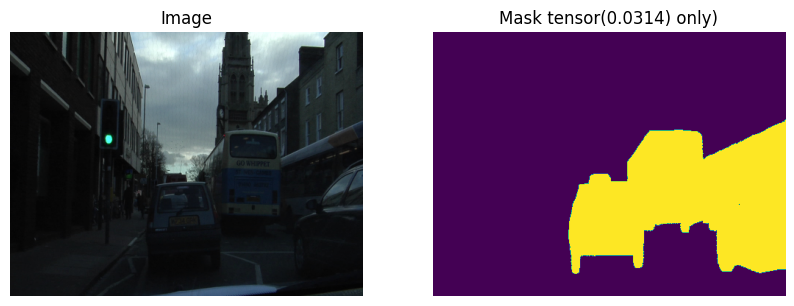

In [223]:
mask_number = 7

masked_tensor = torch.where(torch.isin(mask, unique_value[mask_number]), mask, torch.tensor(0))
unique_value = torch.unique(masked_tensor)

img, masked_tensor = img.permute(1, 2, 0), masked_tensor.permute(1, 2, 0)
img, masked_tensor = img.detach().numpy().copy(), masked_tensor.detach().numpy().copy()

fig, axes = plt.subplots(1, 2, figsize = (10, 5))

axes[0].imshow(img)
axes[0].axis('off')  # 軸を非表示にする
axes[0].set_title("Image")

axes[1].imshow(masked_tensor)
axes[1].axis('off')
axes[1].set_title(f"Mask {str(torch.round(unique_value[1], decimals = 4))} only)")
plt.show()

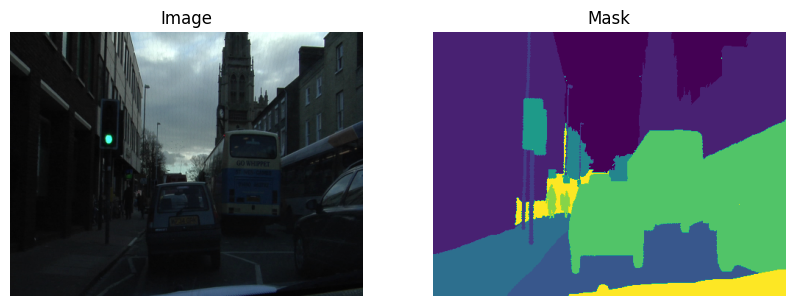

In [224]:

mask = mask.permute(1, 2, 0)
mask = mask.detach().numpy().copy()

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(img)
axes[0].axis('off')  # 軸を非表示にする
axes[0].set_title("Image")

axes[1].imshow(mask)
axes[1].axis('off')
axes[1].set_title("Mask")

plt.show()